### Import Packages and py Files

In [24]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from tokenizer_function import spacy_tokenizer

import pandas as pd
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, Birch, SpectralClustering
import matplotlib.pyplot as plt
%matplotlib inline

### Get Patent Dataframe

In [2]:
df = pd.read_pickle("data/df.pkl")
df.head()

,patent_number,patent_date,patent_title,patent_abstract,patent_firstnamed_assignee_id,patent_year,patent_type,patent_kind,patent_title_and_abstract
0,10603498,2020-03-31,Systems and methods for closed-loop determinat...,A method or system for facilitating the determ...,org_5cFCcVidnLqkMwKWc9s4,2020,utility,B2,Systems and methods for closed-loop determinat...
1,10603793,2020-03-31,Work assisting system including machine learni...,A work assisting system includes a sensor unit...,org_RQZono9Ir8KVdgNAaglV,2020,utility,B2,Work assisting system including machine learni...
2,10603797,2020-03-31,"Machine learning device, robot system, and mac...",A machine learning device for learning a motio...,org_RQZono9Ir8KVdgNAaglV,2020,utility,B2,"Machine learning device, robot system, and mac..."
3,10605228,2020-03-31,Method for controlling operation of a wind tur...,A method for controlling operation of a wind t...,org_VIvs7w0sts1aCjlrKaiG,2020,utility,B2,Method for controlling operation of a wind tur...
4,10605702,2020-03-31,Fluid analysis and monitoring using optical sp...,"Systems, methods, and computer-program product...",org_aHdfa1XsbUURjnXmlGyp,2020,utility,B2,Fluid analysis and monitoring using optical sp...


In [25]:
text_list = df['patent_title_and_abstract']

### Additional Stopwords To Improve Topic Modelling Accuracy

In [3]:
# Add terms that are too generic for this topic modelling task, like "machine, learning, model" etc
additional_stopwords = ['training', 'problem', 'use', 'model', 'machine', 'learning', 'function', 'set', 'data', 'learn',
                        'determine', 'program', 'computer', 'parameter', 'memory', 'node', 'configure', 'sequence',
                        'computing', 'datum', 'compute', 'result', 'generate', 'field', 'file', 'code', 'method', 'test',
                        'interface', 'pattern', 'user', 'employ', 'operation', 'technique', 'analysis', 'neural', 'network',
                        'invention', 'feature', 'object']

### TF-IDF Word2Vec

In [6]:
tfidf_cv = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range = (1,2), stop_words=additional_stopwords)
tfidf_dtm = tfidf_cv.fit_transform(df['patent_title_and_abstract'])

### LSA

In [26]:
lsa = TruncatedSVD(400, algorithm='arpack')
lsa_vecs = lsa.fit_transform(tfidf_dtm)
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)
feature_names = tfidf_cv.get_feature_names()
lsa_df = pd.DataFrame(lsa.components_.round(5), columns=feature_names)

In [27]:
np.save('tf_idf_vecs', tfidf_dtm)
np.save('lsa_vecs', lsa_vecs)
np.save('feature_names', feature_names)
lsa_df.to_pickle('lsa_df.pkl')

## Cluster
### DBSCAN

In [28]:
db = DBSCAN(n_jobs=-1, eps=0.5, min_samples=25)
db_clusters = db.fit_predict(lsa_vecs)

In [29]:
db_2 = DBSCAN(n_jobs=-1, eps=0.6, min_samples=25)
db_2_clusters = db_2.fit_predict(lsa_vecs)

In [30]:
db_3 = DBSCAN(n_jobs=-1, eps=0.7, min_samples=15)
db_3_clusters = db_3.fit_predict(lsa_vecs)

In [31]:
print(len(lsa_vecs))
print(len(db_clusters))
print(len(df))

3147
3147
3147


In [32]:
d = {'db_1_clusters':db_clusters, 'db_2_clusters':db_2_clusters, 'db_3_clusters':db_3_clusters}
db_clusters_df = pd.DataFrame(d)

In [33]:
db_clusters_df.sample(10)

,db_1_clusters,db_2_clusters,db_3_clusters
2354,-1,-1,-1
14,-1,-1,-1
100,-1,-1,-1
2250,-1,-1,-1
2126,-1,-1,-1
2723,-1,-1,-1
1215,-1,-1,-1
1509,-1,-1,-1
2429,-1,-1,-1
1874,-1,-1,-1


### Explore Cluster Sizes

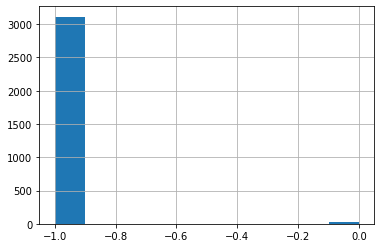

In [34]:
db_clusters_df['db_1_clusters'].hist()

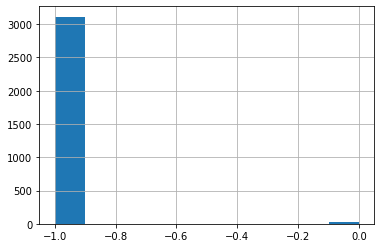

In [35]:
db_clusters_df['db_2_clusters'].hist()

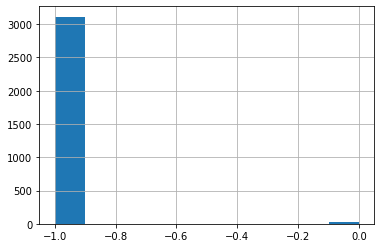

In [36]:
db_clusters_df['db_3_clusters'].hist()

## Outcome
DBSCAN is not a good fit for topic modelling in this scenario due to noisyness of the text corpus. 